# Import Packages

In [64]:
import pydicom
import pandas as pd
import numpy as np
import random
from collections import Counter, defaultdict
import os


import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Configuration

In [65]:
class config:
    
    root = "./hwk02_data"
    valid_prob = 0.3
    batch_size = 16
    lr = 1e-4
    epochs = 200
    weight_decay = 1e-2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


# Input Data

In [66]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))
print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


In [67]:
train_data['Stage'].value_counts().sort_index()

Stage
1    44
2    42
3    75
Name: count, dtype: int64

# Defined functions

In [68]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, ages, genders, labels in train_loader:
        images = images.to(device=device, dtype=torch.float)
        ages = ages.to(device=device, dtype=torch.float)
        genders = genders.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1

def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images, ages, genders)
            labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

# Defined Dataset

In [69]:
class ParkinsonsDataset(Dataset):
    def __init__(self, df, transforms = None): # 將所有資料提出
        self.ages = np.array(df['Age']) # 年齡
        self.genders = np.array(df['Gender']) # 性別
        self.labels = np.array(df['Stage']) # 標籤
        self.indexs = np.array(df['index']) # 起始張數
        self.paths = np.array(df['FilePath']) # 影像路徑
        self.images = []

        # 影像前處理
        for index, path in zip(self.indexs, self.paths):
            image = pydicom.dcmread(config.root+path).pixel_array
            image = torch.tensor(image.astype(np.float32))
            image = image[index-1:index+2, :, :] # 取指定張數和前後共三個, image size = (3, 128, 128)
            if transforms:
                image = transforms(image)
            self.images.append(image)


    def __len__(self):
        return len(self.labels) # label數量

    def __getitem__(self, idx): # 找出指定的資料
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        label = self.labels[idx]
        image = self.images[idx]

        return image, age, gender, label

# Transformation
class My_normalize(object): # 自定義的類別
    # def __init__(self): # 宣告此類別中會使用到的變數

    def __call__(self, image): # 定義有image之後要進行的資料處理
        new_image = (image - image.mean())/(image.max() - image.min())

        return new_image

My_transforms = v2.Compose([
    # 在v2中內建的func
    v2.CenterCrop(size = (50, 50)),
    # 自定義的func
    My_normalize()
])

# Redefined VGG16

In [70]:
class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), out_prob = True, features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 決定是否要將輸出轉換為機率
        self.out_prob = out_prob
        
        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
        vgg16.features[30] = nn.Identity()
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(514, num_classes) # 512: vgg16特徵層結果, 2: age & gender
        )
        self.softmax = nn.Softmax(dim=1) # 每一個row的總和都是1

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3)
        if self.out_prob:
            outputs = self.softmax(outputs)
        return outputs

Initializing dataset...
Initializing test_dataset...
Number of samples in train_dataset: Counter({3: 54, 2: 30, 1: 29})
Number of samples in val_dataset: Counter({3: 21, 1: 15, 2: 12})
Initializing model...
Epoch[1/200], Train Loss: 1.0811, Train Accuracy: 34.51%, Train F1: 26.26% | Valid Loss: 1.0818, Valid Accuracy: 54.17%, Valid F1: 41.20% | LR: 0.000004
Epoch[2/200], Train Loss: 1.0735, Train Accuracy: 48.67%, Train F1: 35.08% | Valid Loss: 1.0761, Valid Accuracy: 62.50%, Valid F1: 46.78% | LR: 0.000004
Epoch[3/200], Train Loss: 1.0747, Train Accuracy: 55.75%, Train F1: 39.98% | Valid Loss: 1.0712, Valid Accuracy: 58.33%, Valid F1: 42.40% | LR: 0.000005
Epoch[4/200], Train Loss: 1.0639, Train Accuracy: 53.10%, Train F1: 36.41% | Valid Loss: 1.0668, Valid Accuracy: 60.42%, Valid F1: 44.65% | LR: 0.000005
Epoch[5/200], Train Loss: 1.0528, Train Accuracy: 54.87%, Train F1: 38.83% | Valid Loss: 1.0623, Valid Accuracy: 56.25%, Valid F1: 40.34% | LR: 0.000006
Epoch[6/200], Train Loss: 1.

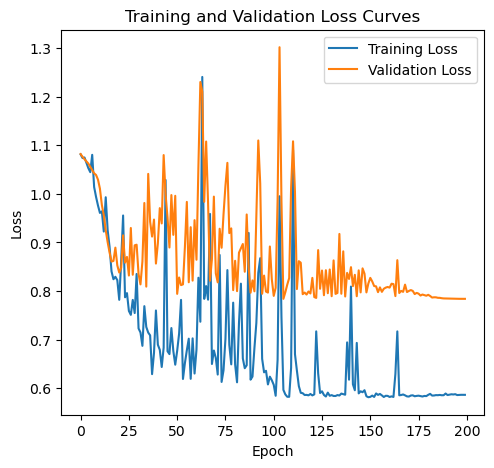

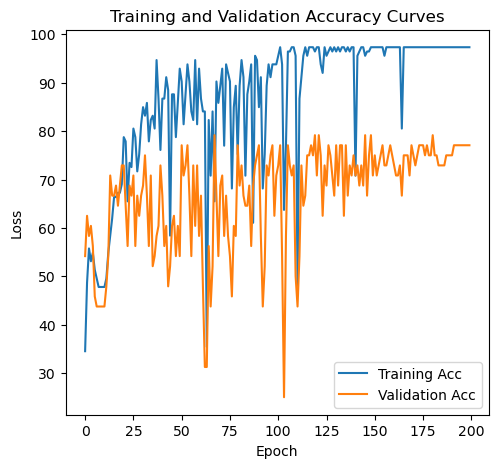

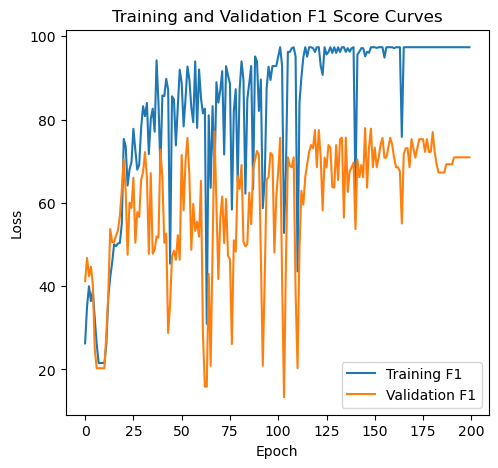

In [71]:
def main():

    seed_everything(config.seed)

    # train & test dataframe
    train_df = pd.read_csv(os.path.join(config.root, 'train.csv'))
    test_df = pd.read_csv(os.path.join(config.root, 'test.csv'))

    # Dataset
    print("Initializing dataset...")
    dataset = ParkinsonsDataset(train_df, transforms = My_transforms)
    print("Initializing test_dataset...")
    test_dataset = ParkinsonsDataset(test_df, transforms = My_transforms)
    
    # split training & validation dataset 
    n = len(dataset)
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    print(f'Number of samples in train_dataset: {Counter(dataset.labels[train_ids])}')
    print(f'Number of samples in val_dataset: {Counter(dataset.labels[valid_ids])}')
    
    # DataLoader
    train_dataset = Subset(dataset, train_ids)
    valid_dataset = Subset(dataset, valid_ids)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    # settings
    print("Initializing model...")
    num_classes = len(Counter(dataset.labels[train_ids]))
    model = VGGplus(num_classes = num_classes, features_grad = True)
    model.to(config.device)
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpointFiles/checkpointDownload2.pth")

        best_ckpt = torch.load("checkpointFiles/checkpointDownload2.pth", map_location=config.device, weights_only = False)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main()

In [72]:
def test(model, test_loader, device):
    model.eval()
    prob = []
    predictions = []
    with torch.no_grad():
        for images, ages, genders, labels in test_loader:
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
           

            logits = model(images, ages, genders)
            preds = torch.argmax(logits, dim=1)
            preds = torch.add(preds, 1)
            predictions.append(preds)
            prob.append(logits)
            
            

        prob = torch.cat(prob)
        predictions = torch.cat(predictions)
    return prob, predictions

In [73]:
### load 最佳模型
model = VGGplus(num_classes = 3)
state_dict = torch.load("checkpointFiles/checkpointDownload2.pth")
model.load_state_dict(state_dict["model"])
model.to(config.device)

C:\Users\mikai\AppData\Local\Temp\ipykernel_50828\2745448528.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("checkpointFiles/checkpointDownload2

VGGplus(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [74]:
### 匯出csv檔
test_df = pd.read_csv(config.root+'/test.csv')
test_dataset = ParkinsonsDataset(test_df, transforms = My_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
logits, prediction = test(model, test_loader, config.device)

submission_df = pd.DataFrame()  # Start with an empty DataFrame
submission_df['ID'] = test_df['ID']

# Add the 'Stage' column with predictions
submission_df['Stage'] = prediction.cpu().numpy()  # Convert preds from GPU to CPU and then to NumPy


# Save the DataFrame to a CSV file
submission_df.to_csv('VGGDownload2.csv', index=False, header=True)  # Save without index and with header